<a href="https://colab.research.google.com/github/MMmichaelMM/DeepLearningCourse/blob/main/LinearClassification1Layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Create the data

In [72]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [73]:
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000  # num_samples_per_class
D = 2     # dimensions
C = 2     # num_classes
H = 100   # num_hidden_units

In [74]:
from torch._C import dtype
#from torch._C import long
negative_samples = np.random.multivariate_normal(
mean=[0, 3],
cov=[[1, 0.5],[0.5, 1]], size=N)
positive_samples = np.random.multivariate_normal(
mean=[3, 0],
cov=[[1, 0.5],[0.5, 1]], size=N)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack((np.zeros((N,1)),np.ones((N,1)))).astype(np.float32)

X = torch.from_numpy(inputs).to(device)
y = torch.from_numpy(targets).to(device)
print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))
print(X) # data (2D points)
print(y) # data labels

Shapes:
X: (2000, 2)
y: (2000, 1)
tensor([[ 1.0643,  4.6004],
        [-0.7506,  4.0677],
        [ 1.4081,  4.3757],
        ...,
        [ 4.5128,  1.0024],
        [ 2.1829, -1.3568],
        [ 2.5366,  0.2426]])
tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])


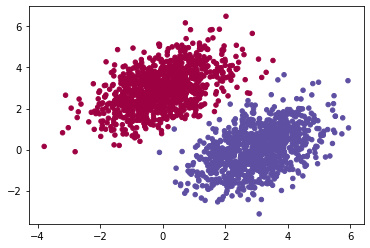

In [75]:
# visualise the data
#plot_data(X, y)
plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)


### Linear model

In [76]:
learning_rate = 1e-3
lambda_l2     = 1e-5

# nn package to create our linear model
# each Linear module has a weight and bias
# model = nn.Sequential(
#         nn.Linear(D, H),
#         nn.Linear(H, C))

model = nn.Sequential(
        nn.Linear(2, 1))

model.to(device) #Convert to CUDA

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = model(X)
    print("y_pred:", tuple(y_pred.size()))
    print(type(y_pred))
    print(type(y))
    # Compute the loss and accuracy
    loss = criterion(y_pred, y)
    print(loss)
    score, predicted = torch.max(y_pred, 1)
    acc = ((abs(y - predicted) < 1e-6)).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %3.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()
    
    # Update params
    optimizer.step()

y_pred: (2000, 1)
<class 'torch.Tensor'>
<class 'torch.Tensor'>
tensor(0.0284, grad_fn=<MseLossBackward0>)
[EPOCH]: 999, [LOSS]: 0.028352, [ACCURACY]: 1000.000


Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


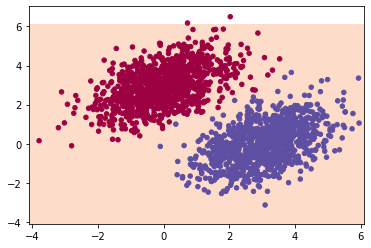

In [77]:
# Plot trained model
print(model)
model.cpu()
mesh = np.arange(-4.1, 6.1, 0.01)
xx, yy = np.meshgrid(mesh, mesh)
with torch.no_grad():
    data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
    Z = model(data).detach()
Z = np.argmax(Z, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)

In [78]:
# show model weigths
l0 = model[0]

w1 = l0.weight[0,0].item()
w2 = l0.weight[0,1].item()
b = l0.bias.item()
print(w1)
print(w2)
print(b)

0.16517114639282227
-0.13169948756694794
0.43284761905670166


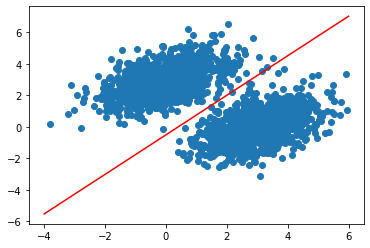

In [80]:
xs = np.linspace(-4,6,100)
ys = -w1/w2*xs+(0.5 - b)/w2
plt.plot(xs,ys, 'r')
plt.scatter(inputs[:, 0], inputs[:, 1])
plt.show()